# **Social network Graph Link Prediction - Facebook**



### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like NO. of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb

### NOTE: the if/else statement is used to to check if you have the file on your machine

> Reading the Graph

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/train_woheader.csv'):
    traincsv = pd.read_csv('/content/drive/MyDrive/data_raw/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/content/drive/MyDrive/data_raw/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/content/drive/MyDrive/data_raw/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


> Displaying a Sub Graph

DiGraph with 66 nodes and 50 edges


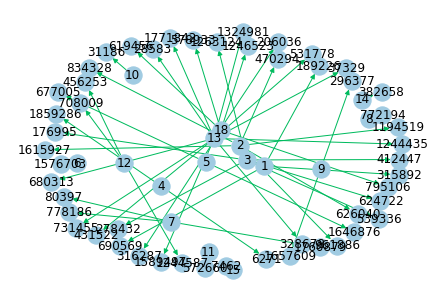

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/train.csv/train_woheader_sample.csv'):
    pd.read_csv('/content/drive/MyDrive/data_raw/train.csv', nrows=50).to_csv('/content/drive/MyDrive/data_raw/train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('/content/drive/MyDrive/data_raw/train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [ ]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No. of followers for each person

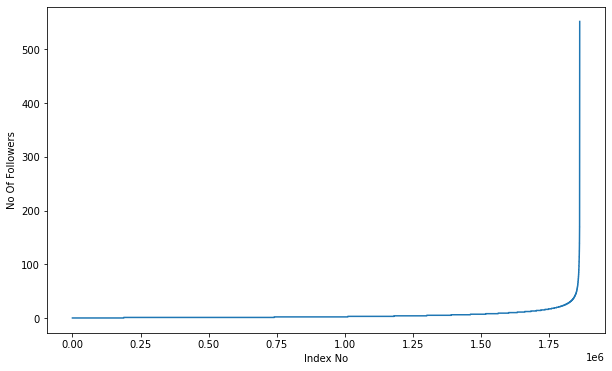

In [ ]:
# here we took all the points

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

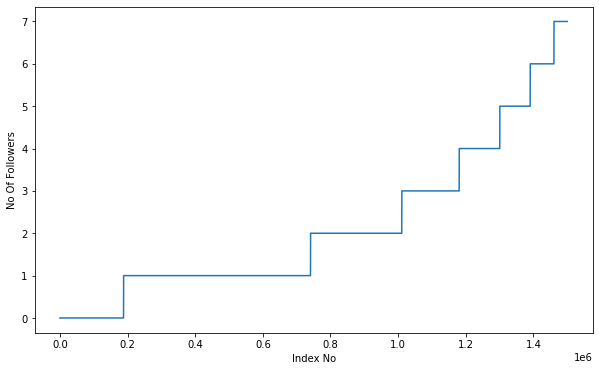

In [ ]:
# here we take 1500000 points in order to zoom in and observe more details

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers <= 40.

In [ ]:
# we zoom in for more insight
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


99.9% of data having followers <= 112.

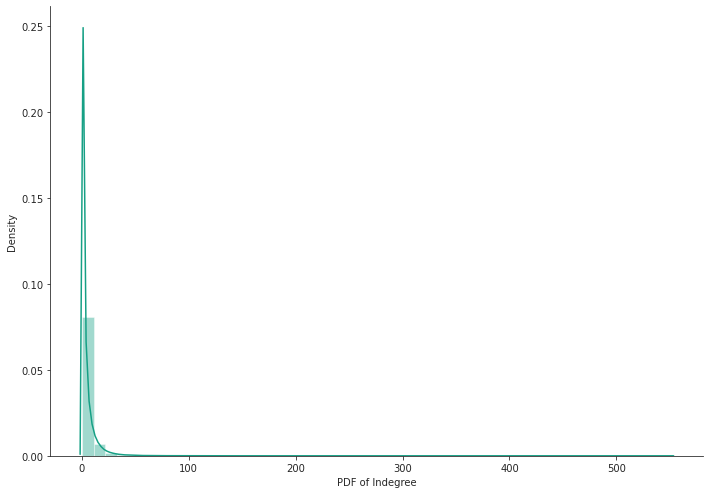

In [ ]:
# plotting the PDF

%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No. of people each person is following

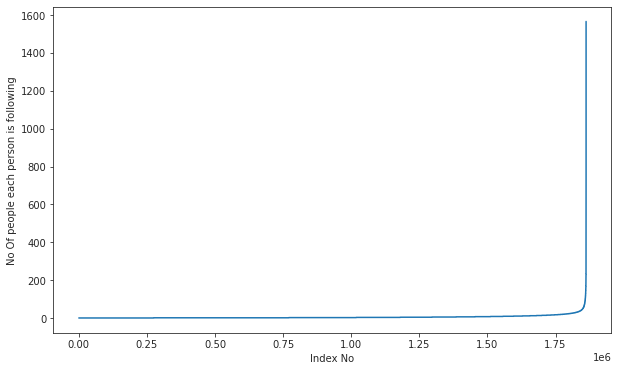

In [ ]:
# here we took all the points

outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

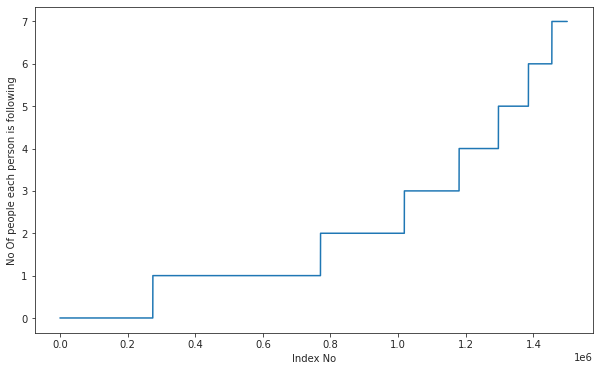

In [ ]:
# here we take 1500000 points in order to zoom in and observe more details

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


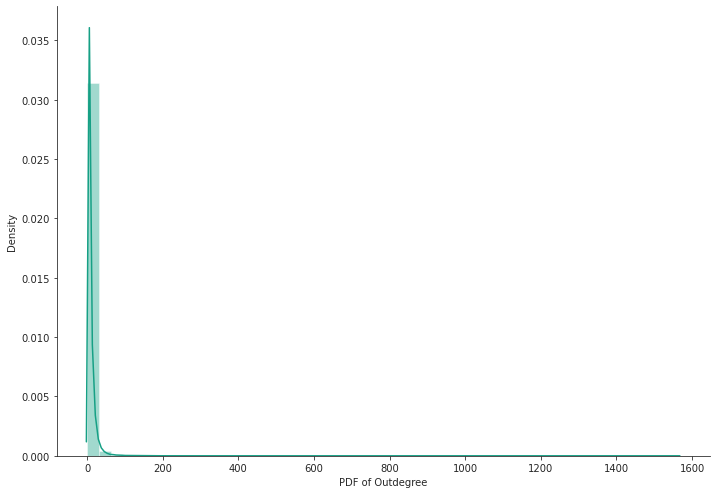

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

**Observation**: 

*   Most of People have small No. of Followers, except for some outlier
*   Most of People Follow small No. of People , except for some outlier



In [ ]:
print('No. of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No. of persons those are not following anyone are 274512 and % is 14.741115442858524


In [ ]:
print('No. of persons having zero followers are' ,sum(np.array(indegree_dist )==0 ),'and % is',
                                sum(np.array(indegree_dist)==0 )*100/len(indegree_dist) )

No. of persons having zero followers are 188043 and % is 10.097786512871734


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No. of persons those are not not following anyone and also not having any followers are',count)

No. of persons those are not not following anyone and also not having any followers are 0


## 1.3 No. of both followers + following for each person

In [ ]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

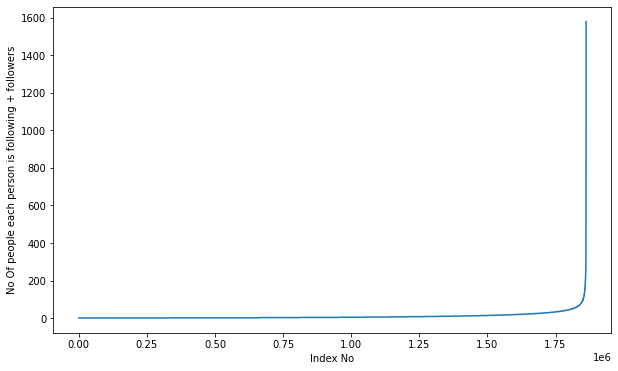

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

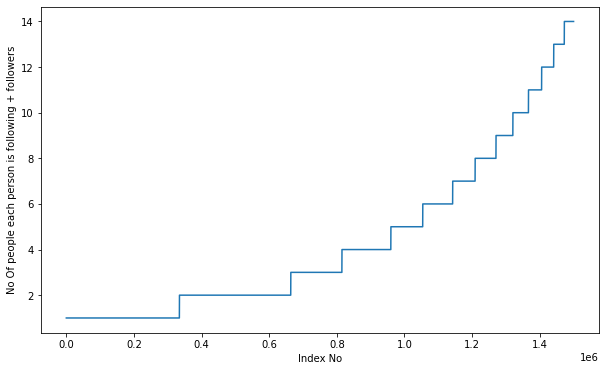

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')
print('% is ',np.sum(in_out_degree==in_out_degree.min())*100/len(in_out_degree) )

Min of no of followers + following is 1
334291  persons having minimum no of followers + following
% is  17.951208772325504


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following', )
print('% is ',np.sum(in_out_degree==in_out_degree.max())*100/len(in_out_degree) )

Max of no of followers + following is 1579
1  persons having maximum no of followers + following
% is  5.369934808991419e-05


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree < 10))
print( '% is', np.sum(in_out_degree < 10)*100/len(in_out_degree))

No of persons having followers + following less than 10 are 1320326
% is 70.90064546616404


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links(link not present in the data but its possbile to have a link in the future) from graph which are not in graph and **whose shortest path is greater than 2**. 

**Explanation:** \
since its a classification problem we need to make another colmun which represent yi's it should contain 1 if there a link(edge) between two nodes and 0 if there is no link(edge). but we only have thoes set nodes amongs which there is a link ( yi's = 1) we don't have yi's = 0( there is no zero labeled data points) **aka** nodes which does not have links so we have to generate them(we will call them bad edges(missing edges nodes).

In [ ]:
%%time
###generating bad edges from given graph (using random sampling cuz all the possplie edges NO. is quite big)
import random
if not os.path.isfile('/content/drive/MyDrive/data_raw/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/content/drive/MyDrive/data_raw/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([]) # missing_edges == zero labled two pairs of vertices(nodes)
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220) # randomly sample two vertices(nodes) a and b
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b: # check if there is no edge(link) between them and the shortest path is greater than 2
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/content/drive/MyDrive/data_raw/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('/content/drive/MyDrive/data_raw/missing_edges_final.p','rb'))



CPU times: user 2.2 s, sys: 1.17 s, total: 3.38 s
Wall time: 5.01 s


In [ ]:
'''
Bottom line we create a set of vertices(nodes)
which size is the same size as our trian.csv size(the nodes which has links(edges)
and which does not have a link(edge) 0 labled data(yi's = 0)
'''
len(missing_edges)

9437519

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [ ]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv')) and (not os.path.isfile('/content/drive/MyDrive/data_raw/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('/content/drive/MyDrive/data_raw/train.csv') # postive df
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node']) # negative df
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    '''
    we slipt positive links and negative links seperatly because we need positive training data only for creating graph 
    and for feature generation
    '''
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('/content/drive/MyDrive/data_raw/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('/content/drive/MyDrive/data_raw/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('/content/drive/MyDrive/data_raw/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [ ]:
if (os.path.isfile('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv')) and (os.path.isfile('/content/drive/MyDrive/data_raw/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('/content/drive/MyDrive/data_raw/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print('Train Graph')
    print(nx.info(train_graph))
    print('Test Graph')
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Train Graph
DiGraph with 1780722 nodes and 7550015 edges
Test Graph
DiGraph with 1144623 nodes and 1887504 edges
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


> we have a cold start problem here(it means there is 7% of my points in my test data which i have no info about in my trian data (clueless)

In [ ]:
#final train and test data sets
X_train_pos = pd.read_csv('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv('/content/drive/MyDrive/data_raw/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv('/content/drive/MyDrive/data_raw/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv('/content/drive/MyDrive/data_raw/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

X_train.to_csv('/content/drive/MyDrive/data_raw/train_after_eda.csv',header=False,index=False)
X_test.to_csv('/content/drive/MyDrive/data_raw/test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('/content/drive/MyDrive/data_raw/train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('/content/drive/MyDrive/data_raw/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


# 3. Featurization (Feature Engineering)

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
\
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs # svd(singular value decomposition), eigs(eigenvalues and eigenvectors)
import gc
from tqdm import tqdm

## 3.1 Reading Data

In [ ]:
if os.path.isfile('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/MyDrive/data_raw/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


## 3.2 Similarity measures

### 3.2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

**the larger the jacard index the higher the probability that there is exist an edge between two nodes**

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [ ]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [ ]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
#one test case
print(jaccard_for_followers(263084,470294))

0


In [ ]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


### 3.2.1 Cosine distance:

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [ ]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followees(273084,1505602))

0.0


In [ ]:
print(cosine_for_followees(273084,1635354))

0


In [ ]:
#for followers
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [ ]:
print(cosine_for_followers(669354,1635354))

0


## 3.3 Ranking measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='https://upload.wikimedia.org/wikipedia/en/8/8b/PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

### 3.3.1 Page Rank

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/page_rank.p'):
  pr = nx.pagerank(train_graph, alpha=0.85) # 0.85 defualt hyperparameter
  pickle.dump(pr,open('/content/drive/MyDrive/data_raw/page_rank.p', 'wb'))
else:
  pr = pickle.load(open('/content/drive/MyDrive/data_raw/page_rank.p','rb'))

In [ ]:
print('min', pr[min(pr, key=pr.get)])
print('max', pr[max(pr, key=pr.get)])
print('mean', float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.709825134193587e-05
mean 5.615699699389075e-07


In [ ]:
# for imputing to nodes which are not there in Train data( in the cold problem cuz there is some data in test which not present in trian)
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


## 3.4 Other Graph Features

### 3.4.1 Shortest Path

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [ ]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
  p = -1 #no edge

  try:
    if train_graph.has_edge(a,b):
      train_graph.remove_edge(a,b) #remove the edge
      p = nx.shortest_path_length(train_graph, source=a, target=b) #get the shortest path
      train_graph.add_edge(a,b) #add the egde again
    else:
      p= nx.shortest_path_length(train_graph,source=a,target=b)
    return p
  except:
    return -1

In [ ]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [ ]:
#testing
compute_shortest_path_length(1,1635354)

8

### 3.4.2 Checking for same community (Weekly Connected Component)

**Strongly connected component(SCC):** is the portion of a directed graph in which there is a path from each vertex to another vertex. It is applicable only on a directed graph.

**Weakly connected component(WCC):** is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges. In case of an undirected graph, a weakly connected component is also a strongly connected component.

In [ ]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a,b): #determine if two nodes belong to the same WCC (return one if True 0 if False)
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc: # for the sets inside the list wcc
                if a in i: 
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [ ]:
#testing
belongs_to_same_wcc(861, 1659750)

0

### 3.4.3 Adamic/Adar Index
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

**in a nut shell:** The definition is based on the concept that common elements with very large neighbourhoods are less significant when predicting a connection between two nodes compared with elements shared between a small number of nodes.

In [ ]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [ ]:
#testing
calc_adar_in(1,189226)

0

### 3.4.4 Is the person following me back

In [ ]:
def follows_back(a,b):
  if train_graph.has_edge(b,a):
    return 1
  else:
    return 0

In [ ]:
#testing
follows_back(1,189226)

1

### 3.4.5 Katz Centrality

https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

**NOTE: its very similar to pageRank algo**

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('/content/drive/MyDrive/data_raw/katz.p','wb'))
else:
    katz = pickle.load(open('/content/drive/MyDrive/data_raw/katz.p','rb'))

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [ ]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


### 3.4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('/content/drive/MyDrive/data_raw/hits.p','wb'))
else:
    hits = pickle.load(open('/content/drive/MyDrive/data_raw/hits.p','rb'))

In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -1.0879811303501434e-20
max 0.004868653379538981
mean 5.615699699308681e-07


# 4. Featurization 2 (**Apply Featurization for test and trian data**)

## 4. 1 Reading a sample of Data from both train and test

### 4.1.1 Sampling

In [ ]:
import random
if os.path.isfile('/content/drive/MyDrive/data_raw/train_after_eda.csv'):
    filename = "/content/drive/MyDrive/data_raw/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    # n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [ ]:
if os.path.isfile('/content/drive/MyDrive/data_raw/train_after_eda.csv'):
    filename = "/content/drive/MyDrive/data_raw/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    # n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [ ]:
print("Number of rows in the train data file:",n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100030
Number of rows we are going to elimiate in train data are 15000030
Number of rows in the test data file: 3775008
Number of rows we are going to elimiate in test data are 3725008


### 4.1.2 Creating data frame from trian and test

In [ ]:
# for trian data
df_final_train = pd.read_csv('/content/drive/MyDrive/data_raw/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/MyDrive/data_raw/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(5)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1814022,1791177,1
2,826445,1364513,1
3,944692,559417,1
4,1814537,613441,1


In [ ]:
# for test data
df_final_test = pd.read_csv('/content/drive/MyDrive/data_raw/test_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/MyDrive/data_raw/test_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_test.shape)
df_final_test.head(5)

Our train matrix size  (24937, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1562045,1824397,1
2,1425191,1817922,1
3,502690,550442,1
4,1199100,991335,1


## 4.2 Adding a set of features

__we will create each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s (num of followers for source</li>
<li>num_followees_s (num of followees for source)</li>
<li>num_followers_d (num of followers for destination)</li>
<li>num_followees_d (num of followees for destination)</li>
<li>inter_followers (intersection of followers)</li>
<li>inter_followees(intersection of followees)</li>
</ol>

In [ ]:
# if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage1.h5'):

# mapping jaccard followers for trian and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row: jaccard_for_followers(row['source_node'],row['destination_node']), axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row: jaccard_for_followers(row['source_node'],row['destination_node']), axis=1)

# mapping jaccard followees for trian and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row: jaccard_for_followees(row['source_node'],row['destination_node']), axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row: jaccard_for_followees(row['source_node'],row['destination_node']), axis=1)

# mapping cosine followers for trian and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']), axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']), axis=1)

# mapping cosine followees for trian and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']), axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']), axis=1)



In [ ]:
def compute_features_stage1(df_final):
    #calculating no. of followers and followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]

    # for each node
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node'])) # for each node 
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train) # unpacking the values to its corresponding colmuns for train 
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test) # unpacking the values to its corresponding colmuns for test
    
    # strore the data frame for trian and test
    hdf = HDFStore('/content/drive/MyDrive/data_raw/storage_sample_stage1.h5')
    hdf.put('/content/drive/MyDrive/data_raw/train_df',df_final_train, format='table', data_columns=True)
    hdf.put('/content/drive/MyDrive/data_raw/test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage1.h5', '/content/drive/MyDrive/data_raw/train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage1.h5', '/content/drive/MyDrive/data_raw/test_df',mode='r')

In [ ]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000


## 4.3 Adding new set of features

__we will create each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage2.h5'): 
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on test
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('/content/drive/MyDrive/data_raw/storage_sample_stage2.h5')
    hdf.put('/content/drive/MyDrive/data_raw/train_df',df_final_train, format='table', data_columns=True)
    hdf.put('/content/drive/MyDrive/data_raw/test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage2.h5', '/content/drive/MyDrive/data_raw/train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage2.h5', '/content/drive/MyDrive/data_raw/test_df',mode='r')

In [ ]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5


## 4.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [ ]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:17<00:00, 103871.92it/s]


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage3.h5'):

    #mapping to pandas train for source & destination nodes
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test source & destination nodes
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights for trian data
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights for test data
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage3.h5'):

    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test 
    #if anything not there in train graph then adding 0
    # hits[0] means calculating for hubs
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    # hits[1] means calculating for authorities
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('/content/drive/MyDrive/data_raw/storage_sample_stage3.h5')
    hdf.put('/content/drive/MyDrive/data_raw/train_df',df_final_train, format='table', data_columns=True)
    hdf.put('/content/drive/MyDrive/data_raw/test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

else:
    df_final_train = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage3.h5', '/content/drive/MyDrive/data_raw/train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage3.h5', '/content/drive/MyDrive/data_raw/test_df',mode='r')

In [ ]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226338e-16,2.231877e-15
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,2.848986e-07,8.815667e-07,0.000735,0.000739,1.269882e-25,5.132992e-22,-4.228372e-25,1.769218e-23
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904,4.125339e-07,3.670567e-07,0.000767,0.000759,5.111827e-18,4.366027e-17,1.470239e-18,7.401076e-19
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641,4.157247e-07,4.305786e-07,0.000765,0.000747,4.139790e-17,-0.000000e+00,1.300593e-11,2.189555e-15
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416,6.228469e-07,2.121543e-06,0.000766,0.000804,4.023255e-15,4.931377e-14,1.272032e-15,7.589346e-15


## 4.4 Adding new set of features

__we will create each of these features for both train and test data points__


### 4.4.1 SVD features for both source and destination


In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
# creating the adjacency matrix
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5'):
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================

    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================

    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5')
    hdf.put('/content/drive/MyDrive/data_raw/train_df',df_final_train, format='table', data_columns=True)
    hdf.put('/content/drive/MyDrive/data_raw/test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

In [ ]:
df_final_train.head(5)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226338e-16,2.231877e-15,-1.666334e-13,4.613820e-13,1.043041e-05,6.678033e-13,2.451105e-13,3.584945e-12,-2.038018e-11,5.397910e-13,1.068943e-06,1.192461e-12,2.279488e-12,3.581202e-12,-7.216151e-13,3.926263e-13,1.983700e-06,1.545089e-13,8.108438e-13,1.719704e-14,-1.355369e-12,4.675320e-13,1.128586e-06,6.616718e-14,9.771079e-13,4.160011e-14
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,2.848986e-07,8.815667e-07,0.000735,0.000739,1.269882e-25,5.132992e-22,-4.228372e-25,1.769218e-23,2.664749e-20,-1.157780e-20,5.054768e-21,-4.121226e-21,-6.844900e-21,-2.419884e-21,-2.345005e-19,3.794328e-19,1.201924e-15,1.979214e-18,2.475750e-19,1.240339e-19,-2.375419e-21,3.780707e-21,1.166711e-17,1.891645e-20,1.978105e-21,8.812075e-22,4.100889e-22,-1.109874e-22,-7.564718e-22,1.294405e-22,-1.703874e-21,-1.242423e-21
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904,4.125339e-07,3.670567e-07,0.000767,0.000759,5.111827e-18,4.366027e-17,1.470239e-18,7.401076e-19,-1.496567e-15,1.305161e-09,6.575124e-12,1.439959e-16,1.157901e-11,9.443999e-17,-1.093941e-14,1.904798e-09,1.301123e-11,3.456752e-16,1.169048e-11,8.056866e-16,-9.158861e-16,3.320511e-09,1.542778e-11,1.787406e-16,1.205198e-12,2.740117e-17,-5.886752e-16,1.802078e-09,2.204444e-11,1.555496e-16,1.273806e-12,1.378817e-17
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641,4.157247e-07,4.305786e-07,0.000765,0.000747,4.139790e-17,-0.000000e+00,1.300593e-11,2.189555e-15,-2.715901e-13,1.596690e-11,6.804195e-11,3.135976e-14,3.712109e-13,7.639383e-16,-5.758625e-20,1.193430e-20,-1.261849e-19,4.548044e-20,-2.548690e-19,-2.305486e-19,-1.760238e-11,3.160858e-10,8.484276e-08,4.211469e-10,3.800009e-10,2.424184e-10,-5.288898e-13,5.425534e-13,1.850888e-11,1.384282e-12,4.168514e-12,4.081128e-14
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416,6.228469e-07,2.121543e-06,0.000766,0.000804,4.023255e-15,4.931377e-14,1.272032e-15,7.589346e-15,-1.122041e-10,1.215834e-10,5.107618e-10,1.554413e-12,1.532345e-11,7.422604e-14,-1.391821e-10,2.144762e-11,2.764876e-10,3.858866e-11,4.866720e-11,9.098049e-13,-4.543506e-12,1.113034e-11,9.458169e-11,8.173488e-13,1.271341e-12,2.370950e-14,-1.350728e-11,7.361995e-12,9.126301e-10,3.804457e-12,7.956920e-12,1.414584e-13


### 4.4.2 Preferential Attachment

Preferential Attachment: Users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

http://be.amazd.com/link-prediction/

In [ ]:
df_final_train['Preferential_Attachment'] = df_final_train.num_followers_s * df_final_train.num_followers_d
df_final_test['Preferential_Attachment'] = df_final_test.num_followers_s * df_final_test.num_followers_d


hdf = HDFStore('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5')
hdf.put('/content/drive/MyDrive/data_raw/train_df',df_final_train, format='table', data_columns=True)
hdf.put('/content/drive/MyDrive/data_raw/test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [ ]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment
0,273084,1505602,1,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226338e-16,2.231877e-15,-1.666334e-13,4.613820e-13,1.043041e-05,6.678033e-13,2.451105e-13,3.584945e-12,-2.038018e-11,5.397910e-13,1.068943e-06,1.192461e-12,2.279488e-12,3.581202e-12,-7.216151e-13,3.926263e-13,1.983700e-06,1.545089e-13,8.108438e-13,1.719704e-14,-1.355369e-12,4.675320e-13,1.128586e-06,6.616718e-14,9.771079e-13,4.160011e-14,165
1,1814022,1791177,1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,2.848986e-07,8.815667e-07,0.000735,0.000739,1.269882e-25,5.132992e-22,-4.228372e-25,1.769218e-23,2.664749e-20,-1.157780e-20,5.054768e-21,-4.121226e-21,-6.844900e-21,-2.419884e-21,-2.345005e-19,3.794328e-19,1.201924e-15,1.979214e-18,2.475750e-19,1.240339e-19,-2.375419e-21,3.780707e-21,1.166711e-17,1.891645e-20,1.978105e-21,8.812075e-22,4.100889e-22,-1.109874e-22,-7.564718e-22,1.294405e-22,-1.703874e-21,-1.242423e-21,1
2,826445,1364513,1,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904,4.125339e-07,3.670567e-07,0.000767,0.000759,5.111827e-18,4.366027e-17,1.470239e-18,7.401076e-19,-1.496567e-15,1.305161e-09,6.575124e-12,1.439959e-16,1.157901e-11,9.443999e-17,-1.093941e-14,1.904798e-09,1.301123e-11,3.456752e-16,1.169048e-11,8.056866e-16,-9.158861e-16,3.320511e-09,1.542778e-11,1.787406e-16,1.205198e-12,2.740117e-17,-5.886752e-16,1.802078e-09,2.204444e-11,1.555496e-16,1.273806e-12,1.378817e-17,99
3,944692,559417,1,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641,4.157247e-07,4.305786e-07,0.000765,0.000747,4.139790e-17,-0.000000e+00,1.300593e-11,2.189555e-15,-2.715901e-13,1.596690e-11,6.804195e-11,3.135976e-14,3.712109e-13,7.639383e-16,-5.758625e-20,1.193430e-20,-1.261849e-19,4.548044e-20,-2.548690e-19,-2.305486e-19,-1.760238e-11,3.160858e-10,8.484276e-08,4.211469e-10,3.800009e-10,2.424184e-10,-5.288898e-13,5.425534e-13,1.850888e-11,1.384282e-12,4.168514e-12,4.081128e-14,32
4,1814537,613441,1,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416,6.228469e-07,2.121543e-06,0.000766,0.000804,4.023255e-15,4.931377e-14,1.272032e-15,7.589346e-15,-1.122041e-10,1.215834e-10,5.107618e-10,1.554413e-12,1.532345e-11,7.422604e-14,-1.391821e-10,2.144762e-11,2.764876e-10,3.858866e-11,4.866720e-11,9.098049e-13,-4.543506e-12,1.113034e-11,9.458169e-11,8.173488e-13,1.271341e-12,2.370950e-14,-1.350728e-11,7.361995e-12,9.126301e-10,3.804457e-12,7.956920e-12,1.414584e-13,216


# 5. Modeling

In [ ]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
# note: test data means also cross validation also
df_final_train = pd.read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5', '/content/drive/MyDrive/data_raw/train_df',mode='r')
df_final_test = pd.read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5', '/content/drive/MyDrive/data_raw/test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'Preferential_Attachment'],
      dtype='object')

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
df_final_train.head(5)

,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment
0,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226338e-16,2.231877e-15,-1.666334e-13,4.613820e-13,1.043041e-05,6.678033e-13,2.451105e-13,3.584945e-12,-2.038018e-11,5.397910e-13,1.068943e-06,1.192461e-12,2.279488e-12,3.581202e-12,-7.216151e-13,3.926263e-13,1.983700e-06,1.545089e-13,8.108438e-13,1.719704e-14,-1.355369e-12,4.675320e-13,1.128586e-06,6.616718e-14,9.771079e-13,4.160011e-14,165
1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,2.848986e-07,8.815667e-07,0.000735,0.000739,1.269882e-25,5.132992e-22,-4.228372e-25,1.769218e-23,2.664749e-20,-1.157780e-20,5.054768e-21,-4.121226e-21,-6.844900e-21,-2.419884e-21,-2.345005e-19,3.794328e-19,1.201924e-15,1.979214e-18,2.475750e-19,1.240339e-19,-2.375419e-21,3.780707e-21,1.166711e-17,1.891645e-20,1.978105e-21,8.812075e-22,4.100889e-22,-1.109874e-22,-7.564718e-22,1.294405e-22,-1.703874e-21,-1.242423e-21,1
2,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904,4.125339e-07,3.670567e-07,0.000767,0.000759,5.111827e-18,4.366027e-17,1.470239e-18,7.401076e-19,-1.496567e-15,1.305161e-09,6.575124e-12,1.439959e-16,1.157901e-11,9.443999e-17,-1.093941e-14,1.904798e-09,1.301123e-11,3.456752e-16,1.169048e-11,8.056866e-16,-9.158861e-16,3.320511e-09,1.542778e-11,1.787406e-16,1.205198e-12,2.740117e-17,-5.886752e-16,1.802078e-09,2.204444e-11,1.555496e-16,1.273806e-12,1.378817e-17,99
3,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641,4.157247e-07,4.305786e-07,0.000765,0.000747,4.139790e-17,-0.000000e+00,1.300593e-11,2.189555e-15,-2.715901e-13,1.596690e-11,6.804195e-11,3.135976e-14,3.712109e-13,7.639383e-16,-5.758625e-20,1.193430e-20,-1.261849e-19,4.548044e-20,-2.548690e-19,-2.305486e-19,-1.760238e-11,3.160858e-10,8.484276e-08,4.211469e-10,3.800009e-10,2.424184e-10,-5.288898e-13,5.425534e-13,1.850888e-11,1.384282e-12,4.168514e-12,4.081128e-14,32
4,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416,6.228469e-07,2.121543e-06,0.000766,0.000804,4.023255e-15,4.931377e-14,1.272032e-15,7.589346e-15,-1.122041e-10,1.215834e-10,5.107618e-10,1.554413e-12,1.532345e-11,7.422604e-14,-1.391821e-10,2.144762e-11,2.764876e-10,3.858866e-11,4.866720e-11,9.098049e-13,-4.543506e-12,1.113034e-11,9.458169e-11,8.173488e-13,1.271341e-12,2.370950e-14,-1.350728e-11,7.361995e-12,9.126301e-10,3.804457e-12,7.956920e-12,1.414584e-13,216


## 5.1 Hyperparameter Tuning

we are using **Random Forest** as a model because:
<ol>
<li>the number of features is reasonable(not large)</li>
<li> taking take care of nonlinearity automatically</li>
</ol>

Estimators =  10 Train Score 0.9203206633246611 test Score 0.9203967446592065
Estimators =  50 Train Score 0.9194858977442665 test Score 0.9157721934587701
Estimators =  100 Train Score 0.9208268289872079 test Score 0.9198940330515958
Estimators =  250 Train Score 0.9198659545502147 test Score 0.9190029843218024
Estimators =  450 Train Score 0.9213671453560842 test Score 0.9201530504982551


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

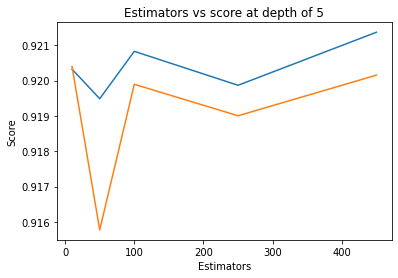

In [ ]:
# hyperparameter tuning for the estimators
estimators = [10,50,100,250,450]
train_scores = []
test_scores = [] # also CV
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8732596188805956 test Score 0.8596903270702854
depth =  9 Train Score 0.9555752175970699 test Score 0.9261534550692709
depth =  11 Train Score 0.9605344043276915 test Score 0.9279065831782027
depth =  15 Train Score 0.9645831632236467 test Score 0.9281548474347054
depth =  20 Train Score 0.9659284323817482 test Score 0.9297867848849484
depth =  35 Train Score 0.9657921024198316 test Score 0.927147271726707
depth =  50 Train Score 0.9657921024198316 test Score 0.927147271726707
depth =  70 Train Score 0.9657921024198316 test Score 0.927147271726707
depth =  130 Train Score 0.9657921024198316 test Score 0.927147271726707


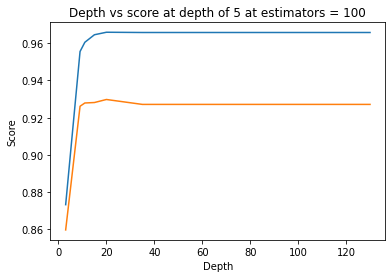

In [ ]:
# hyperparameter tuning for the depth(depth of the base learners)
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 100')
plt.show()

In [ ]:
# hyperparameter tuning... (Randomized Search cross validate)

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(90,115),
              "max_depth": sp_randint(5,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])


In [ ]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])

mean test scores [0.95514676 0.96292175 0.96336278 0.9636046  0.95735291]


In [ ]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=165,
                       min_weight_fraction_leaf=0.0, n_estimators=93, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [ ]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=165,
                       min_weight_fraction_leaf=0.0, n_estimators=93, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

## 5.2 Performance Matrices

In [ ]:
# f1 score
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9643856809877146
Test f1 score 0.9255157253973622


Train confusion_matrix


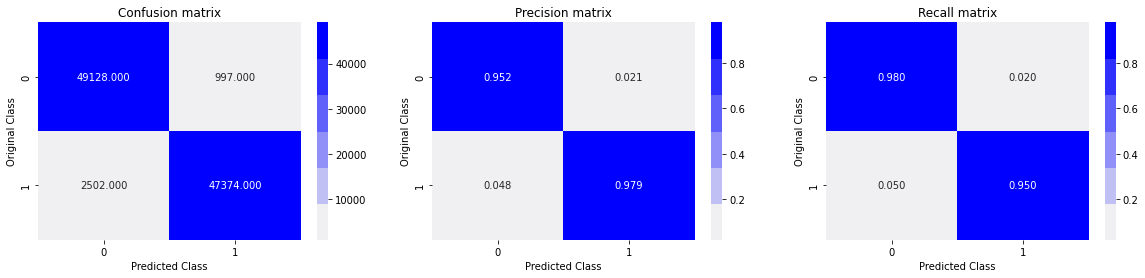

Test confusion_matrix


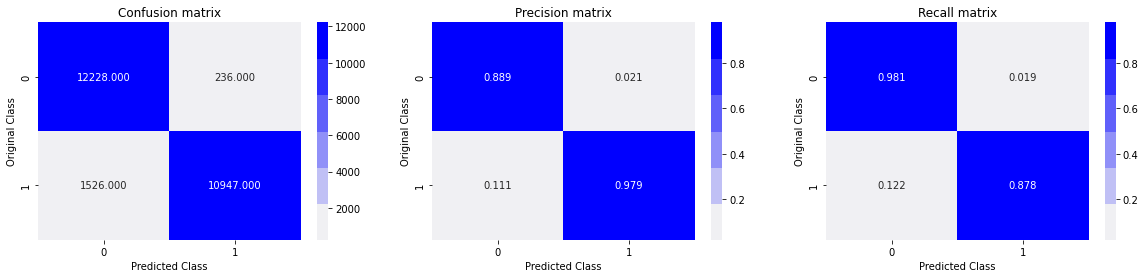

In [ ]:
# confusion metrix

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

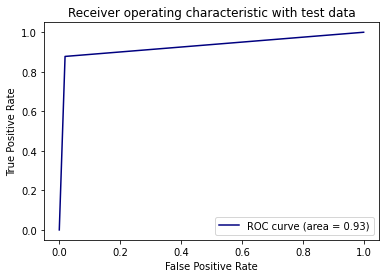

In [ ]:
# ROC-AUC mertrix

from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## 5.3 feature importance

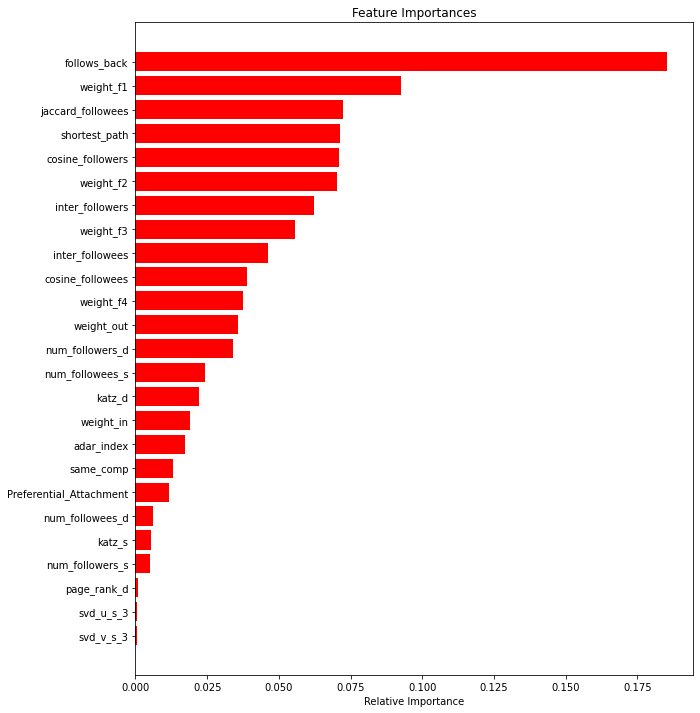

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# 6. Using XGBoot Model (With Hyperparameter Tuning)

credit: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h2_4

In [ ]:
import xgboost as xgb
from sklearn import metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
# note: test data means also cross validation also
df_final_train = pd.read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5', '/content/drive/MyDrive/data_raw/train_df',mode='r')
df_final_test = pd.read_hdf('/content/drive/MyDrive/data_raw/storage_sample_stage4.h5', '/content/drive/MyDrive/data_raw/test_df',mode='r')

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
df_final_train.head(5)

,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment
0,11,15,6,8,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226338e-16,2.231877e-15,-1.666334e-13,4.613820e-13,1.043041e-05,6.678033e-13,2.451105e-13,3.584945e-12,-2.038018e-11,5.397910e-13,1.068943e-06,1.192461e-12,2.279488e-12,3.581202e-12,-7.216151e-13,3.926263e-13,1.983700e-06,1.545089e-13,8.108438e-13,1.719704e-14,-1.355369e-12,4.675320e-13,1.128586e-06,6.616718e-14,9.771079e-13,4.160011e-14,165
1,1,1,2,4,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,-1,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,2.848986e-07,8.815667e-07,0.000735,0.000739,1.269882e-25,5.132992e-22,-4.228372e-25,1.769218e-23,2.664749e-20,-1.157780e-20,5.054768e-21,-4.121226e-21,-6.844900e-21,-2.419884e-21,-2.345005e-19,3.794328e-19,1.201924e-15,1.979214e-18,2.475750e-19,1.240339e-19,-2.375419e-21,3.780707e-21,1.166711e-17,1.891645e-20,1.978105e-21,8.812075e-22,4.100889e-22,-1.109874e-22,-7.564718e-22,1.294405e-22,-1.703874e-21,-1.242423e-21,1
2,9,11,7,12,5,8,0,0.533333,0.238095,0.696311,6.349752,1,1,2,0.353553,0.288675,0.642229,0.102062,0.995782,0.930904,4.125339e-07,3.670567e-07,0.000767,0.000759,5.111827e-18,4.366027e-17,1.470239e-18,7.401076e-19,-1.496567e-15,1.305161e-09,6.575124e-12,1.439959e-16,1.157901e-11,9.443999e-17,-1.093941e-14,1.904798e-09,1.301123e-11,3.456752e-16,1.169048e-11,8.056866e-16,-9.158861e-16,3.320511e-09,1.542778e-11,1.787406e-16,1.205198e-12,2.740117e-17,-5.886752e-16,1.802078e-09,2.204444e-11,1.555496e-16,1.273806e-12,1.378817e-17,99
3,8,4,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,1,7,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641,4.157247e-07,4.305786e-07,0.000765,0.000747,4.139790e-17,-0.000000e+00,1.300593e-11,2.189555e-15,-2.715901e-13,1.596690e-11,6.804195e-11,3.135976e-14,3.712109e-13,7.639383e-16,-5.758625e-20,1.193430e-20,-1.261849e-19,4.548044e-20,-2.548690e-19,-2.305486e-19,-1.760238e-11,3.160858e-10,8.484276e-08,4.211469e-10,3.800009e-10,2.424184e-10,-5.288898e-13,5.425534e-13,1.850888e-11,1.384282e-12,4.168514e-12,4.081128e-14,32
4,9,24,18,21,0,0,0,0.000000,0.000000,0.000000,0.000000,1,1,5,0.229416,0.200000,0.429416,0.045883,0.658831,0.629416,6.228469e-07,2.121543e-06,0.000766,0.000804,4.023255e-15,4.931377e-14,1.272032e-15,7.589346e-15,-1.122041e-10,1.215834e-10,5.107618e-10,1.554413e-12,1.532345e-11,7.422604e-14,-1.391821e-10,2.144762e-11,2.764876e-10,3.858866e-11,4.866720e-11,9.098049e-13,-4.543506e-12,1.113034e-11,9.458169e-11,8.173488e-13,1.271341e-12,2.370950e-14,-1.350728e-11,7.361995e-12,9.126301e-10,3.804457e-12,7.956920e-12,1.414584e-13,216


In [ ]:
#  create XGBoost models , perform cross-validation and plot features importance
# also Model Report like Accuracy and AUC Score for trian data

def modelfit(alg, dtrain, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    
    features = dtrain.columns
    importances = alg.feature_importances_
    indices = (np.argsort(importances))[-25:]
    plt.figure(figsize=(10,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## 6.1 Without tunning


Model Report
Accuracy : 0.9999
AUC Score (Train): 1.000000


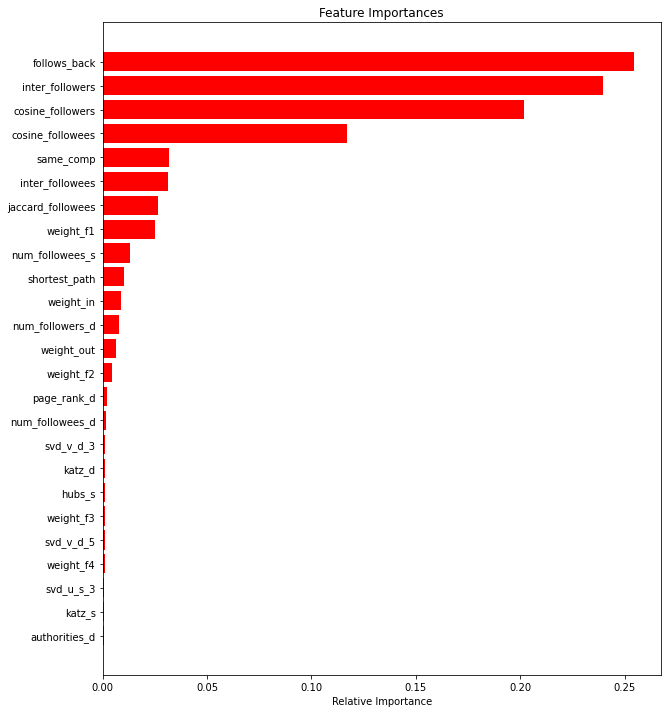

In [ ]:

# %%time
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


modelfit(xgb1, df_final_train, y_train)

In [ ]:
y_train_pred1 = xgb1.predict(df_final_train)
y_test_pred1 = xgb1.predict(df_final_test)

In [ ]:
#f1 score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9773574555834341
Test f1 score 0.9343707713125846


Train confusion_matrix


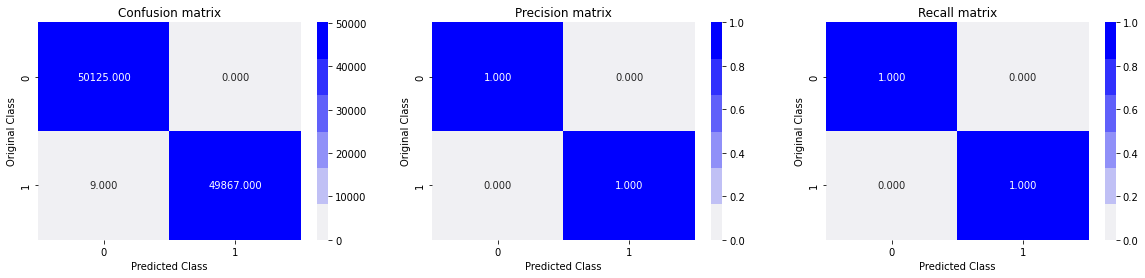

Test confusion_matrix


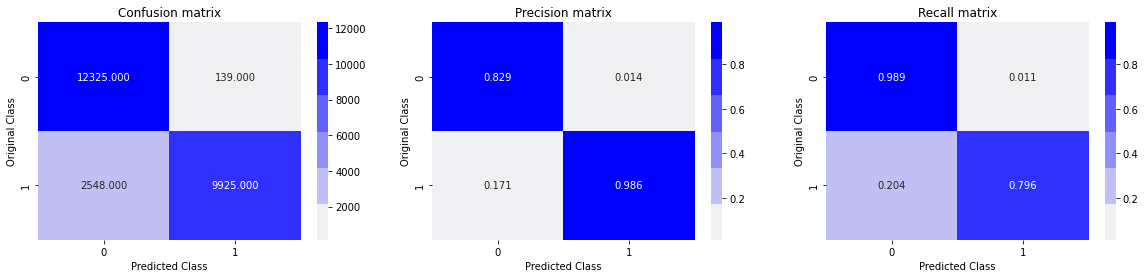

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred1)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred1)

## 6.2 Tune max_depth and min_child_weight

**We tune these first as they will have the highest impact on model outcome**

In [ ]:
param_test1 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(df_final_train, y_train)



In [ ]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([117.60209055, 118.65480461, 118.19331827, 144.68628225,
         142.90851202, 142.84110146, 170.47189317, 169.23256326,
         141.34667325]),
  'mean_score_time': array([0.3678843 , 0.40350976, 0.43002129, 0.45034356, 0.47057018,
         0.44773183, 0.53685918, 0.53038602, 0.37908483]),
  'mean_test_score': array([0.997723  , 0.997673  , 0.9977135 , 0.99815544, 0.99815569,
         0.99815859, 0.99842931, 0.99841561, 0.99843368]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 4},
   {'max_depth': 

In [ ]:
param_test2 = {
 'max_depth':[7,8,9,10],
 'min_child_weight':[7,8,9,10]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_child_weight': [7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False

In [ ]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([190.01221142, 189.71799364, 188.70190296, 190.01420493,
         211.67293115, 209.28460903, 208.68195667, 209.08327169,
         232.82802982, 231.60584469, 231.22857075, 228.7414125 ,
         253.53730559, 250.17140412, 246.88511853, 245.1337965 ]),
  'mean_score_time': array([0.47819114, 0.59449501, 0.57177587, 0.56907306, 0.58422222,
         0.5228219 , 0.64780364, 0.62401037, 0.6523047 , 0.6479568 ,
         0.62581573, 0.59366679, 0.66875148, 0.72328477, 0.65081887,
         0.46226873]),
  'mean_test_score': array([0.99860249, 0.99859173, 0.99858253, 0.998579  , 0.99870812,
         0.99869966, 0.99870612, 0.9987187 , 0.9988146 , 0.99879329,
         0.99879076, 0.99880361, 0.99884058, 0.99883316, 0.99882518,
         0.99882768]),
  'param_max_depth': masked_array(data=[7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, Fals

## 6.3 Tunning gamma

In [ ]:
param_test3 = {
  'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=7,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([250.97332397, 249.98664575, 250.1692214 , 252.30742087,
         214.72053881]),
  'mean_score_time': array([0.65590968, 0.66591325, 0.72731447, 0.71328616, 0.48147211]),
  'mean_test_score': array([0.99884058, 0.99883509, 0.99885611, 0.99885151, 0.99885203]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([4, 5, 1, 3, 2], dtype=int32),
  'split0_test_score': array([0.99888722, 0.99891632, 0.99896333, 0.99893916, 0.99891845]),
  'split1_test_score': array([0.99892997, 0.99893262, 0.99892547, 0.99892148, 0.99887488]),
  'split2_test_score': array([0.99882076, 0.99876029, 0.99877668, 0.99879803, 0.99883816]),
  'split3_test_score': array([0.99878296, 0.9987447 , 0.99878812, 0.99877783, 0.99880861]),
  'split

## 6.4 Tune subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/100.0 for i in range(75,85,3)],
 'colsample_bytree':[i/100.0 for i in range(75,85,3)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
 min_child_weight=7, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=7,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.78, 0.81, 0.84],
                         'subsample': [0.75, 0.78, 0.81, 0.84]},
             pre_dispatch='2*n_jobs', refit=True,

In [ ]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([235.570473  , 236.23596563, 239.04924269, 239.93095174,
         244.4130547 , 244.6220418 , 246.75687461, 248.38518929,
         248.87230654, 248.65668945, 251.13647399, 250.75480199,
         256.37255545, 259.66866598, 262.91221271, 260.29757671]),
  'mean_score_time': array([0.66089964, 0.68318667, 0.72992539, 0.71064763, 0.7072299 ,
         0.72435651, 0.70141058, 0.71850119, 0.70679121, 0.72508807,
         0.692837  , 0.68924966, 0.71037035, 0.71885371, 0.70118976,
         0.49447203]),
  'mean_test_score': array([0.99882545, 0.99884775, 0.99884611, 0.99882668, 0.99883563,
         0.99883718, 0.99882577, 0.99883051, 0.99885578, 0.99885512,
         0.99883256, 0.99883066, 0.998847  , 0.99886345, 0.99882621,
         0.99884178]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.75, 0.78, 0.78, 0.78, 0.78, 0.81,
                     0.81, 0.81, 0.81, 0.84, 0.84, 0.84, 0.84],
               mask=[False, False, False, False, False, Fa

## 6.5 Tuning Regularization Parameters

In [ ]:
param_test5 = {
  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
 min_child_weight=7, gamma=0.2, subsample=0.78, colsample_bytree=0.84,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.84, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=7,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.78, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0

In [ ]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([258.62904606, 259.98172197, 258.49448886, 259.73904834,
         218.62111206]),
  'mean_score_time': array([0.62057791, 0.59407854, 0.64932775, 0.57510047, 0.44020553]),
  'mean_test_score': array([0.99886344, 0.99886976, 0.99886911, 0.9988455 , 0.99864432]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 10],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 10}],
  'rank_test_score': array([3, 1, 2, 4, 5], dtype=int32),
  'split0_test_score': array([0.99900124, 0.99892055, 0.998956  , 0.99889906, 0.99872347]),
  'split1_test_score': array([0.998925  , 0.99901079, 0.99893381, 0.9989243 , 0.99877759]),
  'split2_test_score': array([0.99879118, 0.99883658, 0.99880617, 0.99876391, 0.9985121 ]),
  'split3_test_score': array([0.99879386, 0.99874325, 0.99880553, 0.99878941


Model Report
Accuracy : 0.9777
AUC Score (Train): 0.997797


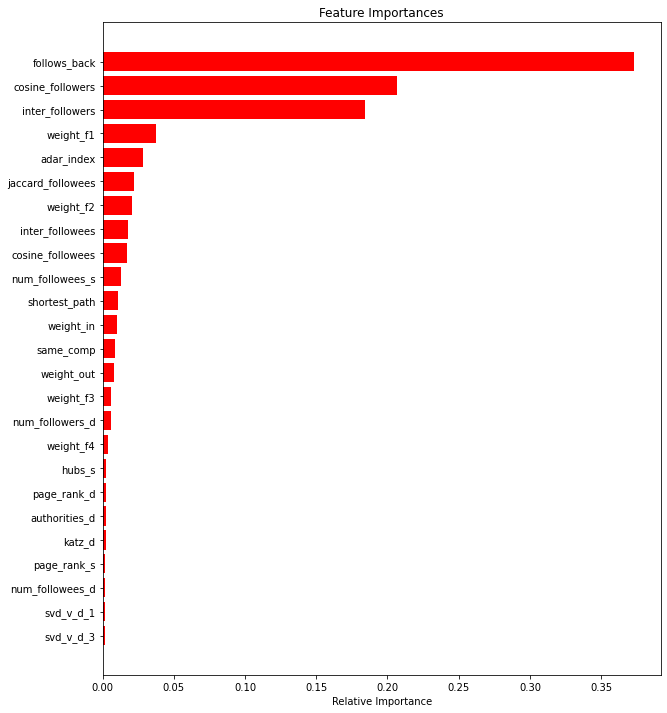

In [ ]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.01, #Reducing Learning Rate
 n_estimators=140, 
 max_depth=10,
 min_child_weight=7,
 gamma=0.2,
 subsample=0.78,
 colsample_bytree=0.84,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, df_final_train, y_train)

In [ ]:
y_train_pred = xgb3.predict(df_final_train)
y_test_pred = xgb3.predict(df_final_test)

In [ ]:
#f1 score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9773574555834341
Test f1 score 0.9343707713125846


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


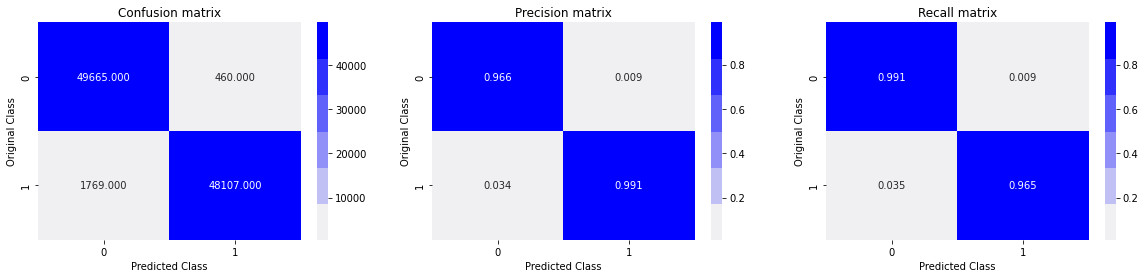

Test confusion_matrix


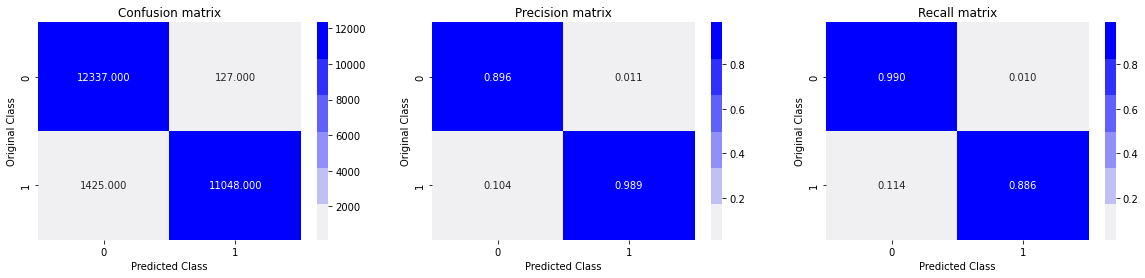

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

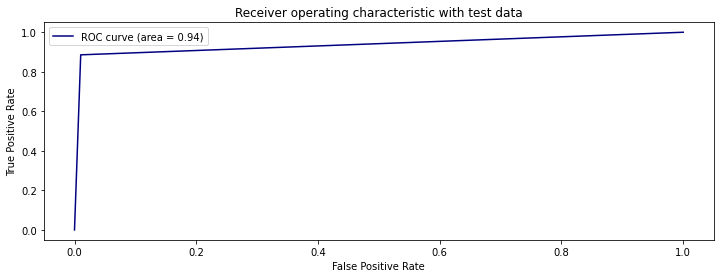

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
#dump the model
pickle.dump(xgb3, open("/content/drive/MyDrive/data_raw/xgb_fine_tuned_clf1_1.pickle.dat", "wb"))

# **Conclusion**

<ol>
<li>The performance of XGBoost is better as compared with the Random Forest</li>
<li>we could've engineer more features or creating ensemble of models, stacking, etc</li>
<li>we have cold start problem thats why there's diffrence between test f1 score and trian f1 score</li>
</ol>


In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["ALgorithm", "Train F1 Score","Test F1 Score", "train - test precision&recall"]

x.add_row(["Random Forest", "0.9643856809877146","0.9255157253973622", "Medium Gap"])
x.add_row(["XGBoost (without fine tuning)", "0.9773574555834341","0.9343707713125846", "Big Gap"])
x.add_row(["XGBoost (with fine tuning)", "0.9773574555834341","0.9343707713125846", "Small Gap"])
print(x)

+-------------------------------+--------------------+--------------------+-------------------------------+
|           ALgorithm           |   Train F1 Score   |   Test F1 Score    | train - test precision&recall |
+-------------------------------+--------------------+--------------------+-------------------------------+
|         Random Forest         | 0.9643856809877146 | 0.9255157253973622 |           Medium Gap          |
| XGBoost (without fine tuning) | 0.9773574555834341 | 0.9343707713125846 |            Big Gap            |
|   XGBoost (with fine tuning)  | 0.9773574555834341 | 0.9343707713125846 |           Small Gap           |
+-------------------------------+--------------------+--------------------+-------------------------------+
